Name: Darren King
Student_ID: 17145031

In [298]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.random_projection import GaussianRandomProjection
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.cluster import AgglomerativeClustering

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## Exploratory Data Analysis

In [299]:
df = pd.read_csv("insurance.csv")
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


Our independent variables are age, gender, bmi, children, smoker, region.
Our dependent variable is insurance_cost

In [300]:
df.dtypes

age                 int64
gender             object
bmi               float64
children            int64
smoker             object
region             object
insurance_cost    float64
dtype: object

In [301]:
categorical = ['gender', 'smoker', 'region']
df[categorical].nunique()


gender    2
smoker    2
region    4
dtype: int64

In [302]:
# Check for missing values:

df.isna().sum()


age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

There are no missing values

In [303]:
# Check for outliers using describe and boxplots

df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The numerical data all looks reasonable, no unexpected or 'impossible' numerical values for the numerical categories; the min and max of the insurance cost, are, unsurprisingly, significantly seperated. But this is our dependent variable...

<AxesSubplot:>

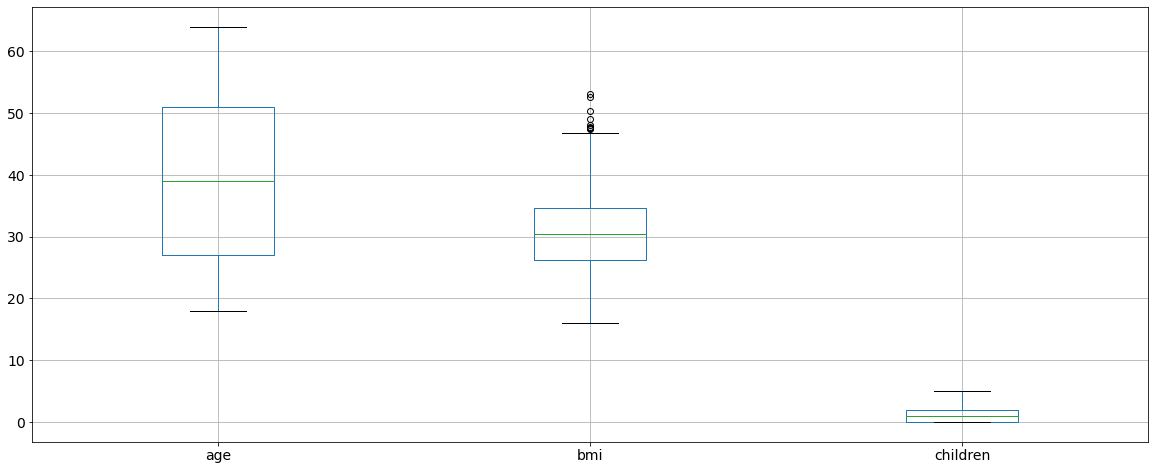

In [304]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,8), fontsize=14)


<AxesSubplot:>

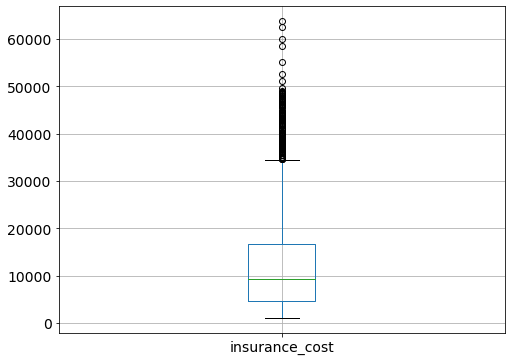

In [305]:
df.boxplot(column=['insurance_cost'], figsize=(8,6), fontsize=14)
# This is our dependent variable, so we're not worried about outliers here as the model needs to be able to predict such
# 'outliers'
# BMI on the other hand has a number of outliers and therefore we will need to scale this variable differently to the others.

## Data Preparation

In [306]:
# One hot encoding of the categorical values

df = pd.get_dummies(df, columns= categorical, drop_first= False)
# I prefer to keep all the columns with one hot encoding, especially given the 4 regions aren't as intuitive as
# gender and smoker (could drop the first for smoking and gender if wanted).

In [307]:
df.head()

,age,bmi,children,insurance_cost,gender_female,gender_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
1,18,34.100,0,1137.01100,0,1,1,0,0,0,1,0
2,18,26.315,0,2198.18985,1,0,1,0,1,0,0,0
3,18,38.665,2,3393.35635,1,0,1,0,1,0,0,0
4,18,35.625,0,2211.13075,1,0,1,0,1,0,0,0


In [308]:
# These are all the names of the independent variables
names_all = [c for c in df if c not in ['insurance_cost']]

# These are the names of the independent variables with prominent outliers
names_outliers = ['bmi']

# These are the names of the independent variables without prominent outliers
names_no_outliers = list(set(names_all) - set(names_outliers))

In [309]:
print(names_all)
print(names_no_outliers)

['age', 'bmi', 'children', 'gender_female', 'gender_male', 'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
['smoker_no', 'region_southeast', 'children', 'region_northeast', 'gender_female', 'age', 'region_northwest', 'smoker_yes', 'region_southwest', 'gender_male']


In [310]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    """
    A class to be used in the preprocessing pipeline to put the names of the columns/attributes back
    as we will lose the names of the columns in the train/test split
    We're subclassing from the BaseEstimator and the TransformerMixin to ensure we inherit everything from
    these classes
    """
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [311]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    A class to select a particular group of columns as we won't be preprocessing all the columns in
    the same manner
    """
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [312]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(names_all),
    FeatureUnion(transformer_list=[
        ("outliers", make_pipeline(
            ColumnSelector(names_outliers),
            FunctionTransformer (np.log, validate=True),
            RobustScaler()
        )),
        ("no_outliers", make_pipeline(
            ColumnSelector(names_no_outliers),
            StandardScaler()
        ))
    ])
)

In [313]:
preprocess_pipeline

Pipeline(steps=[('addcolumnnames',
                 AddColumnNames(columns=['age', 'bmi', 'children',
                                         'gender_female', 'gender_male',
                                         'smoker_no', 'smoker_yes',
                                         'region_northeast', 'region_northwest',
                                         'region_southeast',
                                         'region_southwest'])),
                ('featureunion',
                 FeatureUnion(transformer_list=[('outliers',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(columns=['bmi'])),
                                                                 ('functio...
                                                                  FunctionTransformer(func=<ufunc 'log'>,
                                                                                      val

In [314]:
y = df['insurance_cost']

X = df.drop('insurance_cost', axis=1).values

In [315]:
print(y)

0        1725.55230
1        1137.01100
2        2198.18985
3        3393.35635
4        2211.13075
           ...     
1333    16069.08475
1334    29330.98315
1335    14394.55790
1336    49577.66240
1337    26926.51440
Name: insurance_cost, Length: 1338, dtype: float64


In [316]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Random Forest Pipeline

We're going to add dimensionality reduction to the pipeline; we're adding 3 different dimensionality reduction techniques:
1. PCA (Principal Component Analysis)
2. RFE (Reduced Feature Extraction) with a linear SVM
3. RFE (Reduced Feature Extraction) with linear regression

In [ ]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dimensionality', 'passthrough'),
                       ("random_forest_regressor", RandomForestRegressor(random_state=42))])

param_grid = [
    {
        'reduce_dimensionality': [PCA(iterated_power=7, random_state=42)],
        'reduce_dimensionality__n_components': [2,4,6,8,10,11,None],
        'reduce_dimensionality__svd_solver': ['auto', 'full', 'arpack', 'randomized'],
        'random_forest_regressor__n_estimators': [10,20,30,40,50,60,70,80,90,100],
        #'random_forest_regressor__criterion': ["squared_error", "absolute_error", "poisson"],
        'random_forest_regressor__max_depth': [2,4,6,8,10, None]
    },
    {
        'reduce_dimensionality': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dimensionality__n_features_to_select': [2,4,6,8,10,11, None],
        'random_forest_regressor__n_estimators': [10,20,30,40,50,60,70,80,90,100],
        #'random_forest_regressor__criterion': ["squared_error", "absolute_error", "poisson"],
        'random_forest_regressor__max_depth': [2,4,6,8,10, None]
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True) # -1 uses all processors, True uses whole training set
search.fit(X_train, y_train)

In [318]:
print("Best CV Score: ", search.best_score_)
print("Best Parameters: ", search.best_params_)

# We need to store the parameters and the best model for later use in our comparison

rfr_best_cv_score = search.best_score_
rfr_best_params = search.best_params_
rfr_best_model = search.best_estimator_ # This gives us our best estimator out of the gridsearch

Best CV Score:  0.868216140645959
Best Parameters:  {'random_forest_regressor__max_depth': 4, 'random_forest_regressor__n_estimators': 100, 'reduce_dimensionality': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=8), 'reduce_dimensionality__n_features_to_select': 8}


###  Linear Regression Pipeline

In [ ]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dimensionality', 'passthrough'),
                       ("linear_regressor", LinearRegression())])

param_grid = [
    {
        'reduce_dimensionality': [PCA(iterated_power=7, random_state=42)],
        'reduce_dimensionality__n_components': [2,4,6,8,10,11,None],
        'reduce_dimensionality__svd_solver': ['auto', 'full', 'arpack', 'randomized'],
        # 'linear_regressor__normalize': [True, False] - deprecated
    },
    {
        'reduce_dimensionality': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dimensionality__n_features_to_select': [2,4,6,8,10,11, None],
        # 'linear_regressor__normalize': [True, False] - deprecated
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True) # -1 uses all processors, True uses whole training set
search.fit(X_train, y_train)

print("Best CV Score: ", search.best_score_)
print("Best Parameters: ", search.best_params_)

# We need to store the parameters and the best model for later use in our comparison

lr_best_cv_score = search.best_score_
lr_best_params = search.best_params_
lr_best_model = search.best_estimator_ # This gives us our best estimator out of the gridsearch

In [320]:
print("Best CV Score: ", search.best_score_)
print("Best Parameters: ", search.best_params_)

# We need to store the parameters and the best model for later use in our comparison

lr_best_cv_score = search.best_score_
lr_best_params = search.best_params_
lr_best_model = search.best_estimator_ # This gives us our best estimator out of the gridsearch

Best CV Score:  0.7519844777790187
Best Parameters:  {'reduce_dimensionality': PCA(iterated_power=7, n_components=10, random_state=42, svd_solver='randomized'), 'reduce_dimensionality__n_components': 10, 'reduce_dimensionality__svd_solver': 'randomized'}


### Comparing Our Models

In [321]:
def evaluate_model(X_test, y_test, model):

    _y_pred = model.predict(X_test)

    _mse = mean_squared_error(y_test, _y_pred)
    _mae = mean_absolute_error(y_test, _y_pred)
    _r2 = r2_score(y_test, _y_pred)

    return _mse, _mae, _r2

In [322]:
rf_mse, rf_mae, rf_r2 = evaluate_model(X_test, y_test, rfr_best_model)

In [323]:
lr_mse, lr_mae, lr_r2 = evaluate_model(X_test, y_test, lr_best_model)

In [324]:
df_mse = pd.DataFrame({'Random Forest': rf_mse, 'Linear Regression': lr_mse}, index = ['MSE'])
df_mae = pd.DataFrame({'Random Forest': rf_mae, 'Linear Regression': lr_mae}, index = ['MAE'])
df_r2 = pd.DataFrame({'Random Forest': rf_r2, 'Linear Regression': lr_r2}, index = ['R2'])

<AxesSubplot:>

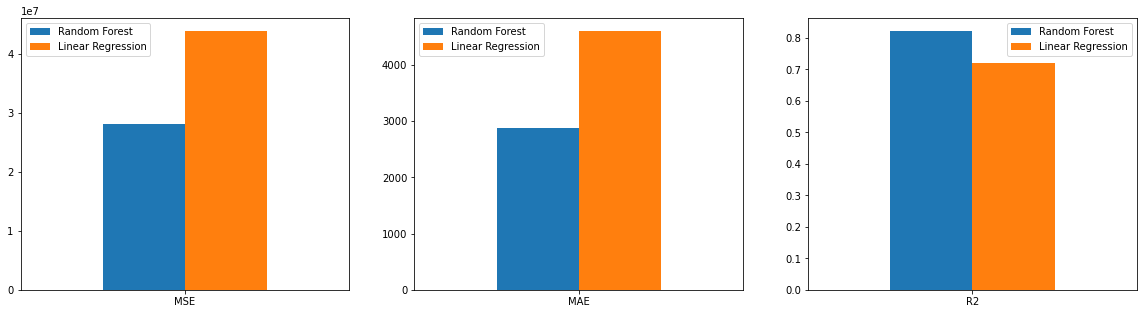

In [325]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

MSE = Mean Squared Error - this is the squared error that our model makes on average; our random forest model makes less error than our linear regression model. We want our errors to be low.

MAE = Mean Absolute Error is the average of the absolute values of the errors, i.e. how far was the model off on average for each prediction. Again our random forest model has a lower MAE than our linear regression model and as such is a better model on the basis of this metric.

R2 = This metric represents the proportion of variance explained by your model. A model which explains no variance would have an r2 of zero and a model that explains all the variance would have an r2 of 1. Simply, the higher the r2 the better. A model with an r2 of 0.5 is able to account for half of the variance in the data. As can be seen above, our random forest model performs better than our linear regression model in relation to this relative metric.

### SGD Regressor (Stochastic Gradient Descent) Pipeline

In [ ]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dimensionality', 'passthrough'),
                       ("sgd_regressor", SGDRegressor(random_state=42))])

param_grid = [
    {
        'reduce_dimensionality': [PCA(iterated_power=7, random_state=42)],
        'reduce_dimensionality__n_components': [2,4,6,8,10,11,None],
        'reduce_dimensionality__svd_solver': ['auto', 'full', 'arpack', 'randomized'],
        'sgd_regressor__penalty': ['l2', 'l1', 'elasticnet'],
        'sgd_regressor__alpha': [0.0001, 0.001, 0.01],
        'sgd_regressor__n_iter_no_change': [5,10,15]

    },
    {
        'reduce_dimensionality': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dimensionality__n_features_to_select': [2,4,6,8,10,11, None],
        'sgd_regressor__penalty': ['l2', 'l1', 'elasticnet'],
        'sgd_regressor__alpha': [0.0001, 0.001, 0.01],
        'sgd_regressor__n_iter_no_change': [5,10,15]
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True) # -1 uses all processors, True uses whole training set
search.fit(X_train, y_train)

In [327]:
print("Best CV Score: ", search.best_score_)
print("Best Parameters: ", search.best_params_)

# We need to store the parameters and the best model for later use in our comparison

sgdr_best_cv_score = search.best_score_
sgdr_best_params = search.best_params_
sgdr_best_model = search.best_estimator_ # This gives us our best estimator out of the gridsearch

Best CV Score:  0.7538983923218054
Best Parameters:  {'reduce_dimensionality': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=8), 'reduce_dimensionality__n_features_to_select': 8, 'sgd_regressor__alpha': 0.01, 'sgd_regressor__n_iter_no_change': 5, 'sgd_regressor__penalty': 'l1'}


In [328]:
sgdr_mse, sgdr_mae, sgdr_r2 = evaluate_model(X_test, y_test, sgdr_best_model)

In [329]:
df_mse['SGD'] = sgdr_mse
df_mae['SGD'] = sgdr_mae
df_r2['SGD'] = sgdr_r2

<AxesSubplot:>

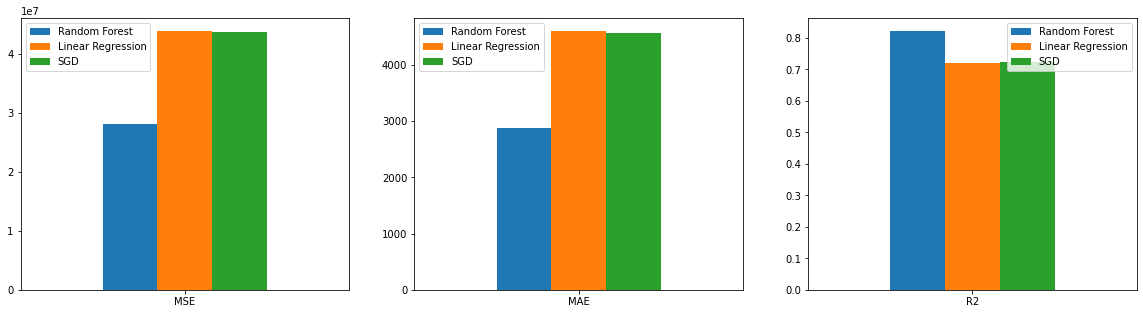

In [330]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

Again, we can see from the above that our Random Forest performs best out of our 3 models. Our linear regression and stocahstic gradient descent models perform very similarly each having a CV score of 0.75

## Addition of alternate Dimensionality Reduction Techniques

So far we have explored a Random Forest, Linear Regression and Stochastic Gradient Descent Regressor with PCA and RFE dimensionality reduction (utilising an SVM and LR estimator in our Recursive Feature Elimination).

With PCA we look for a combination of features that capture the variance within our original dataset well.
Let's explore further dimensionality reduction techniques in our pipeline. We'll start with random projection.
We'll use a Gaussian model to reduce dimensionality through gaussian random projection and see what effect that has on our models.

We will also add in a hierarchial clustering technique for agglomerative clustering to group together features that look very similar and thus decrease the number of features.

In [ ]:
# Looking at the random forest pipline with the addition of a gaussian random projection transformer for dimensionality reduction to the
# grid search to see if we can improve our model

pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dimensionality', 'passthrough'),
                       ("random_forest_regressor", RandomForestRegressor(random_state=42))])

param_grid = [
    {
        'reduce_dimensionality': [PCA(iterated_power=7, random_state=42)],
        'reduce_dimensionality__n_components': [2,4,6,8,10,11,None],
        'reduce_dimensionality__svd_solver': ['auto', 'full', 'arpack', 'randomized'],
        'random_forest_regressor__n_estimators': [10,20,30,40,50,60,70,80,90,100],
        #'random_forest_regressor__criterion': ["squared_error", "absolute_error", "poisson"],
        'random_forest_regressor__max_depth': [2,4,6,8,10, None]
    },
    {
        'reduce_dimensionality': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dimensionality__n_features_to_select': [2,4,6,8,10,11, None],
        'random_forest_regressor__n_estimators': [10,20,30,40,50,60,70,80,90,100],
        #'random_forest_regressor__criterion': ["squared_error", "absolute_error", "poisson"],
        'random_forest_regressor__max_depth': [2,4,6,8,10, None]
    },
    {
        'reduce_dimensionality': [GaussianRandomProjection(random_state=42)],
        'reduce_dimensionality__n_components': [2,4,6,8,10,11,'auto'],
        'random_forest_regressor__n_estimators': [10,20,30,40,50,60,70,80,90,100],
        #'random_forest_regressor__criterion': ["squared_error", "absolute_error", "poisson"],
        'random_forest_regressor__max_depth': [2,4,6,8,10, None]
    },
    {
        'reduce_dimensionality': [AgglomerativeClustering()],
        'reduce_dimensionality__n_clusters': [2,4,6,8,10],
        'reduce_dimensionality__linkage': ['ward', 'complete', 'average'],
        'random_forest_regressor__n_estimators': [10,20,30,40,50,60,70,80,90,100],
        #'random_forest_regressor__criterion': ["squared_error", "absolute_error", "poisson"],
        'random_forest_regressor__max_depth': [2,4,6,8,10, None]
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True) # -1 uses all processors, True uses whole training set
search.fit(X_train, y_train)


In [332]:
print("Best CV Score: ", search.best_score_)
print("Best Parameters: ", search.best_params_)

# We need to store the parameters and the best model for later use in our comparison

rfr_best_cv_score = search.best_score_
rfr_best_params = search.best_params_
rfr_best_model = search.best_estimator_ # This gives us our best estimator out of the gridsearch

Best CV Score:  0.868216140645959
Best Parameters:  {'random_forest_regressor__max_depth': 4, 'random_forest_regressor__n_estimators': 100, 'reduce_dimensionality': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=8), 'reduce_dimensionality__n_features_to_select': 8}


Prior to the introduction of a Gaussian Random Projection transformer in the dimensionality reduction part of the pipeline we were gettging the following results:

Best CV Score:  0.852219526228138
Best Parameters:  {'random_forest_regressor__max_depth': 4, 'random_forest_regressor__n_estimators': 100, 'reduce_dimensionality': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dimensionality__n_features_to_select': 11}

The introduction of the Gaussian Random Projection into our pipeline did not change the performance of our Random Forest model.
Equally, the use of Agglomerative Clustering as a dimensionality reduction technique did not change the best model outcome.

In [ ]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dimensionality', 'passthrough'),
                       ("linear_regressor", LinearRegression())])

param_grid = [
    {
        'reduce_dimensionality': [PCA(iterated_power=7, random_state=42)],
        'reduce_dimensionality__n_components': [2,4,6,8,10,11,None],
        'reduce_dimensionality__svd_solver': ['auto', 'full', 'arpack', 'randomized'],
        # 'linear_regressor__normalize': [True, False] - deprecated
    },
    {
        'reduce_dimensionality': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dimensionality__n_features_to_select': [2,4,6,8,10,11, None],
        # 'linear_regressor__normalize': [True, False] - deprecated
    },
    {
        'reduce_dimensionality': [GaussianRandomProjection(random_state=42)],
        'reduce_dimensionality__n_components': [2,4,6,8,10,11,'auto']
    },
    {
        'reduce_dimensionality': [AgglomerativeClustering()],
        'reduce_dimensionality__n_clusters': [2,4,6,8,10],
        'reduce_dimensionality__linkage': ['ward', 'complete', 'average', 'single']
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True) # -1 uses all processors, True uses whole training set
search.fit(X_train, y_train)

In [334]:
print("Best CV Score: ", search.best_score_)
print("Best Parameters: ", search.best_params_)

# We need to store the parameters and the best model for later use in our comparison

lr_best_cv_score = search.best_score_
lr_best_params = search.best_params_
lr_best_model = search.best_estimator_ # This gives us our best estimator out of the gridsearch

Best CV Score:  0.7519844777790187
Best Parameters:  {'reduce_dimensionality': PCA(iterated_power=7, n_components=10, random_state=42, svd_solver='randomized'), 'reduce_dimensionality__n_components': 10, 'reduce_dimensionality__svd_solver': 'randomized'}


Prior to the introduction of a Gaussian Random Projection transformer in the dimensionality reduction part of the pipeline we were gettging the following results:

Best CV Score:  0.7498012666238445
Best Parameters:  {'reduce_dimensionality': PCA(iterated_power=7, n_components=8, random_state=42), 'reduce_dimensionality__n_components': 8, 'reduce_dimensionality__svd_solver': 'auto'}

The introduction of the Gaussian Random Projection into our pipeline altered the dimensionality reduction technique utilised as the best technique from the Grid Search but the CV score change for our Linear Regression model was insignificant.
The addition of the Agglomerative Clustering technique did not change the best model/estimator.

In [ ]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dimensionality', 'passthrough'),
                       ("sgd_regressor", SGDRegressor(random_state=42))])

param_grid = [
    {
        'reduce_dimensionality': [PCA(iterated_power=7, random_state=42)],
        'reduce_dimensionality__n_components': [2,4,6,8,10,11,None],
        'reduce_dimensionality__svd_solver': ['auto', 'full', 'arpack', 'randomized'],
        'sgd_regressor__penalty': ['l2', 'l1', 'elasticnet'],
        'sgd_regressor__alpha': [0.0001, 0.001, 0.01],
        'sgd_regressor__n_iter_no_change': [5,10,15]

    },
    {
        'reduce_dimensionality': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dimensionality__n_features_to_select': [2,4,6,8,10,11, None],
        'sgd_regressor__penalty': ['l2', 'l1', 'elasticnet'],
        'sgd_regressor__alpha': [0.0001, 0.001, 0.01],
        'sgd_regressor__n_iter_no_change': [5,10,15]
    },
    {
        'reduce_dimensionality': [GaussianRandomProjection(random_state=42)],
        'reduce_dimensionality__n_components': [2,4,6,8,10,11,'auto'],
        'sgd_regressor__penalty': ['l2', 'l1', 'elasticnet'],
        'sgd_regressor__alpha': [0.0001, 0.001, 0.01],
        'sgd_regressor__n_iter_no_change': [5,10,15]
    },
    {
        'reduce_dimensionality': [AgglomerativeClustering()],
        'reduce_dimensionality__n_clusters': [2,4,6,8,10],
        'reduce_dimensionality__linkage': ['ward', 'complete', 'average', 'single'],
        'sgd_regressor__penalty': ['l2', 'l1', 'elasticnet'],
        'sgd_regressor__alpha': [0.0001, 0.001, 0.01],
        'sgd_regressor__n_iter_no_change': [5,10,15]
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True) # -1 uses all processors, True uses whole training set
search.fit(X_train, y_train)

In [336]:
print("Best CV Score: ", search.best_score_)
print("Best Parameters: ", search.best_params_)

# We need to store the parameters and the best model for later use in our comparison

sgdr_best_cv_score = search.best_score_
sgdr_best_params = search.best_params_
sgdr_best_model = search.best_estimator_ # This gives us our best estimator out of the gridsearch

Best CV Score:  0.7538983923218054
Best Parameters:  {'reduce_dimensionality': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=8), 'reduce_dimensionality__n_features_to_select': 8, 'sgd_regressor__alpha': 0.01, 'sgd_regressor__n_iter_no_change': 5, 'sgd_regressor__penalty': 'l1'}


Prior to the introduction of a Gaussian Random Projection transformer in the dimensionality reduction part of the pipeline we were getting the following results:

Best CV Score:  0.7511973097712877
Best Parameters:  {'reduce_dimensionality': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=8), 'reduce_dimensionality__n_features_to_select': 8, 'sgd_regressor__alpha': 0.0001, 'sgd_regressor__n_iter_no_change': 15, 'sgd_regressor__penalty': 'l1'}


The introduction of the Gaussian Random Projection and Agglomerative Clustering into our pipeline did not change the performance of our SGD model.
